# Exercise 1
#### Group 25. Maximilian Laurent Heß, Oleksandra Kravchenko

## Reading the data
Read the three CSV using Pandas. See the pandas.read_csv documentation to check how to parse the CSV correctly! Merge the two datasets player_data_per_36_min.csv and players.csv into one table. Add a team_name column to your new data frame based on the team_id column retrieving the name from the teams.csv dataset. You should now have a table that includes player info from players.csv, and players performance statistics from player_data_per_36_min.csv, and the team’s name from teams.csv.

In [44]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings

warnings.filterwarnings('ignore')

Read the data

In [45]:
players = pd.read_csv("data/players.csv")
teams = pd.read_csv("data/teams.csv")
player_data_per_36_min = pd.read_csv("data/player_data_per_36_min.csv") #Player performance per game is normalized to 36 minutes for performance comparison regardless of playing time.

Check for duplicates

In [46]:
print(
    f"Duplicates in player_data_per_36_min.csv: {len(player_data_per_36_min[player_data_per_36_min.duplicated()==True])}"
)
print(f"Duplicates in players.csv: {len(players[players.duplicated()==True])}")
print(f"Duplicates in teams.csv: {len(teams[teams.duplicated()==True])}")

Duplicates in player_data_per_36_min.csv: 0
Duplicates in players.csv: 0
Duplicates in teams.csv: 0


Merge player_data_per_36_min with players

TODO: Check if team matching is correct. Evtl. müssen wir auch die Liste extrahoeren und jedes Team matchen?

In [47]:
df_helper = players.merge(
    player_data_per_36_min, how="right",     #right join due to 1:n relationship
    left_on="id",
    right_on="player_id"
)

Merge teams into previous df

In [48]:
df_merged = df_helper.merge(
    teams[["team_name", "team_id"]],
    how="left",     #left join due to n:1 relationship
    left_on="current_team_id",
    right_on="team_id",
)

## Data cleaning

Take care of missing values. Sci-kit learn provides different data imputation methods. Remove unusable rows or columns, if necessary.  If the player has no current team, replace the empty value with "Retired".

Replace nan values with None ***Why?*** I just think None makes more sense as it tells you there is no data. NaN just tells that there could be data it is just not a number

In [49]:
df_merged = df_merged.replace({np.nan: None})

Modify the column team_name. If someone is retired, fill "Retired" into the column

In [50]:
df_merged.loc[df_merged["retired"], "team_name"] = "Retired"

Check for differences in the columns

Drop unnecessary columns

In [52]:
df_merged = df_merged.drop(columns=["id_x", "id_y", "player_url", "text"]).sort_values(by="player_id").reset_index(drop = True)

# Max

Plot what percentage of each column is null

Text(0.5, 1.0, 'Percentage of null values per column (0 % excluded)')

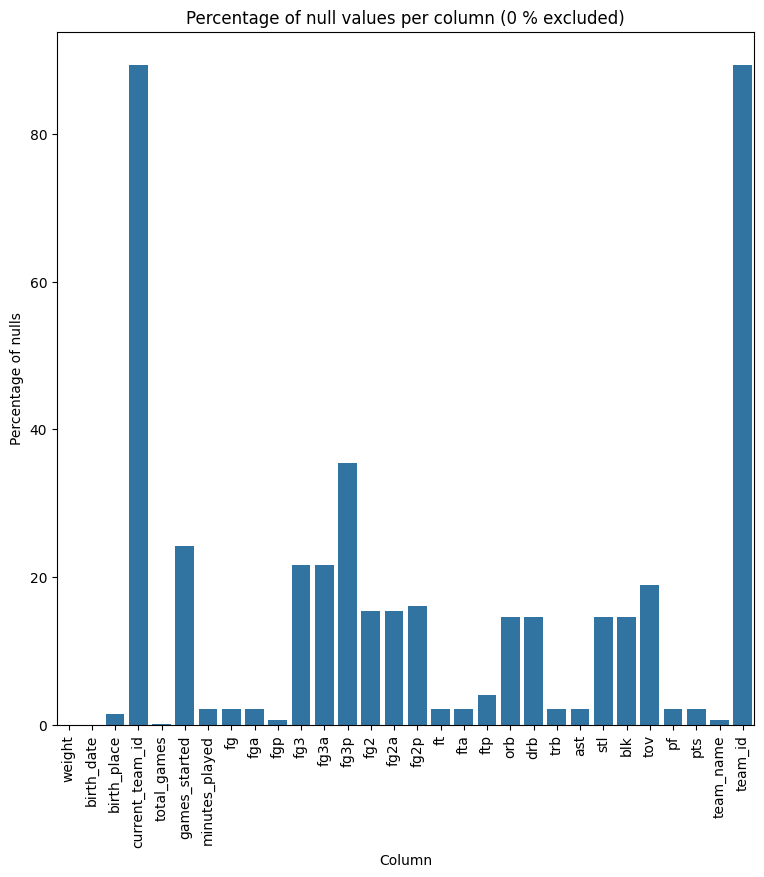

In [8]:
# don't visualize all columns that are zero as there is no need to visualise them
df_null_plot = df_merged.loc[:,df_merged.isnull().sum() != 0]
null_per_column = df_null_plot.isnull().sum()
percentage_per_column = null_per_column/len(df_null_plot)*100
percentage_per_column.apply(lambda x: f"{np.round(x,2)} %")

plt.figure(figsize=(9,9))
ax = sns.barplot(percentage_per_column)
ax.tick_params(axis='x', rotation=90)
ax.set_ylabel("Percentage of nulls")
ax.set_xlabel("Column")
ax.set_title("Percentage of null values per column (0 % excluded)")


Plot a graph to check the impact of nan values

Text(0.5, 1.0, 'Heatmap of nulls per column (columns with zero nulls excluded)')

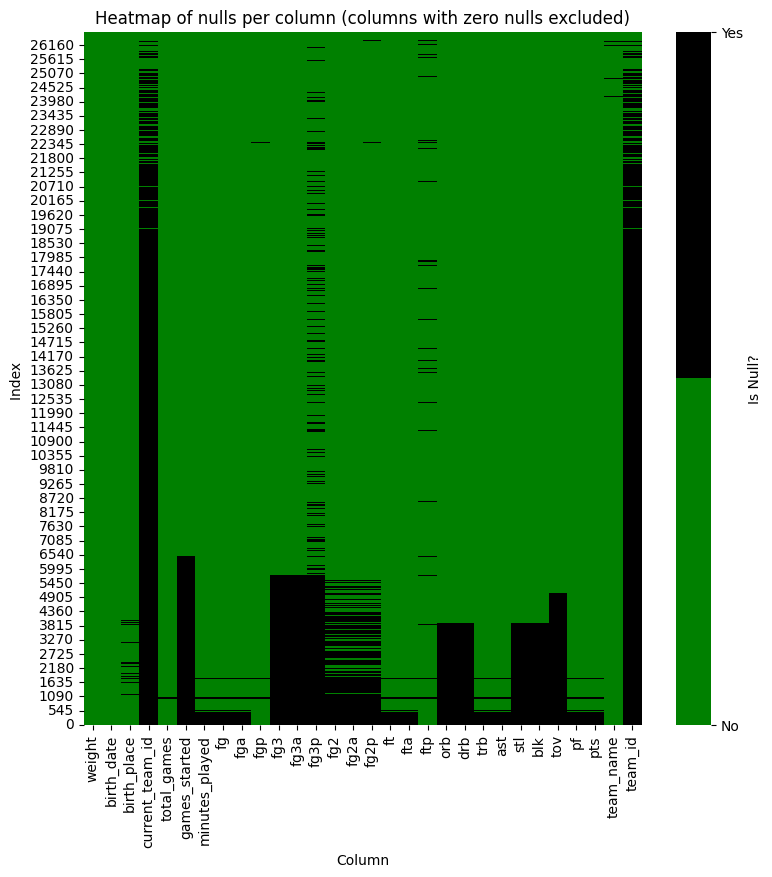

In [9]:
colors = ["green", "black"]
plt.figure(figsize=(9, 9))
ax = sns.heatmap(
    df_null_plot.isnull(),
    cmap=colors,
    cbar_kws={"ticks": [0, 1], "label": "Is Null?"},
)
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([0, 1])
colorbar.set_ticklabels(["No", "Yes"])
ax.invert_yaxis()
ax.set_ylabel("Index ")
ax.set_xlabel("Column")
ax.set_title("Heatmap of nulls per column (columns with zero nulls excluded)")

## Data structuring
Create two new tables: one that groups rows based on player_id, another that groups rows based on team_id.

In [22]:
df_player_id = df_merged.groupby(["player_id", "name"]).sum()
df_player_id

,,id_x,full_name,position,height,weight,birth_date,birth_place,retired,player_url,current_team_id,...,drb,trb,ast,stl,blk,tov,pf,pts,team_name,team_id
player_id,name,,,,,,,,,,,,,,,,,,,,,
1,Alaa Abdelnaby,9,Alaa AbdelnabyAlaa AbdelnabyAlaa AbdelnabyAlaa...,F-CF-CF-CF-CF-CF-CF-CF-CF-C,6-106-106-106-106-106-106-106-106-10,2160.0,June 24 1968June 24 1968June 24 1968June 24 19...,"Cairo, EgyptCairo, EgyptCairo, EgyptCairo, Egy...",9,/players/a/abdelal01.html/players/a/abdelal01....,0,...,56.5,84.2,8.8,6.9,6.9,29.4,47.7,134.3,RetiredRetiredRetiredRetiredRetiredRetiredReti...,0
2,Zaid Abdul-Aziz,28,Zaid Abdul-AzizZaid Abdul-AzizZaid Abdul-AzizZ...,C-FC-FC-FC-FC-FC-FC-FC-FC-FC-FC-FC-FC-FC-F,6-96-96-96-96-96-96-96-96-96-96-96-96-96-9,3290.0,April 7 1946April 7 1946April 7 1946April 7 19...,"Brooklyn, New YorkBrooklyn, New YorkBrooklyn, ...",14,/players/a/abdulza01.html/players/a/abdulza01....,0,...,60.9,191.9,28.4,6.7,10.1,10.7,63.6,203.4,RetiredRetiredRetiredRetiredRetiredRetiredReti...,0
3,Kareem Abdul-Jabbar,60,Kareem Abdul-JabbarKareem Abdul-JabbarKareem A...,CCCCCCCCCCCCCCCCCCCC,7-27-27-27-27-27-27-27-27-27-27-27-27-27-27-27...,4500.0,April 16 1947April 16 1947April 16 1947April 1...,"New York, New YorkNew York, New YorkNew York, ...",20,/players/a/abdulka01.html/players/a/abdulka01....,0,...,119.8,212.2,69.2,15.1,40.7,34.5,59.7,475.1,RetiredRetiredRetiredRetiredRetiredRetiredReti...,0
4,Mahmoud Abdul-Rauf,36,Mahmoud Abdul-RaufMahmoud Abdul-RaufMahmoud Ab...,GGGGGGGGG,6-16-16-16-16-16-16-16-16-1,1458.0,March 9 1969March 9 1969March 9 1969March 9 19...,"Gulfport, MississippiGulfport, MississippiGulf...",9,/players/a/abdulma02.html/players/a/abdulma02....,0,...,17.7,22.2,43.1,9.6,1.0,19.2,24.1,174.5,RetiredRetiredRetiredRetiredRetiredRetiredReti...,0
5,Tariq Abdul-Wahad,50,Tariq Abdul-WahadTariq Abdul-WahadTariq Abdul-...,FFFFFFFFFF,6-66-66-66-66-66-66-66-66-66-6,2230.0,November 3 1974November 3 1974November 3 1974N...,"Maisons Alfort, FranceMaisons Alfort, FranceMa...",10,/players/a/abdulta01.html/players/a/abdulta01....,0,...,39.3,63.5,22.8,14.8,8.0,24.2,42.2,115.6,RetiredRetiredRetiredRetiredRetiredRetiredReti...,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4814,Marial Shayok,4814,Marial Shayok,G,6-5,196.0,July 26 1995,"Ottawa, Canada",0,/players/s/shayoma01.html,29.0,...,10.8,10.8,3.6,0.0,0.0,3.6,0.0,10.8,Utah Jazz,29.0
4817,Jeremiah Martin,4817,Jeremiah Martin,PG,6-3,184.0,January 19 1996,"Memphis, Tennessee",0,/players/m/martije02.html,3.0,...,3.3,3.3,3.3,3.3,0.0,0.0,0.0,6.5,Brooklyn Nets,3.0
4818,William Howard,4818,William Howard,F,6-8,205.0,October 25 1993,"Montbrison, France",0,/players/h/howarwi01.html,11.0,...,5.5,5.5,2.8,0.0,0.0,2.8,2.8,0.0,Houston Rockets,11.0


## Data visualisation
Visualize the data (twice). Every submitted notebook should contain at least two visualizations using at least two different Python visualization libraries. One visualization for each of the new tables (aggregated players or aggregated teams). A list of the most wide-spread Python visualization libraries can be found in this article. You must concisely describe and explain each visualization and your decisions in a Markdown field. You will not receive the points for this task if you did not add a description/explanation. 

### @Sasha
Ich habe folgende Vorschläge, wie wir mit dem droppen umgehen könnten:
1. Wir droppen einfach alle Columns bei welchen die Prozentzahl über einer gewissen thresshold ist
2. Wir schauen uns an ob man evtl. den Durchschnitt für Spieler für manche Statisiken berechnen kann. Ich stelle mir das so vor, dass wenn z.B. 80 % der Werte für einen Spieler vorhanden sind, dass wir dann für die restlichen 20% den Durchschnitt berechnen.


# Sasha

In [ ]:
birth_places = df_merged["birth_place"].unique()

In [ ]:
df_merged["birth_states"] = df_merged["birth_place"].str.split(',', expand=True)[1]
df_merged['birth_states'] = df_merged['birth_states'].apply(lambda x: str(x).replace(u'\xa0', u''))


In [ ]:
all_states = pd.Series(df_merged["birth_states"].unique())

In [ ]:
US_states = [
    'Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado',
    'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho',
    'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
    'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
    'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
    'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
    'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
    'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota',
    'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington',
    'West Virginia', 'Wisconsin', 'Wyoming'
]

US_state_to_code = {
    'Alabama': 'AL', 'Alaska': 'AK', 'Arizona': 'AZ', 'Arkansas': 'AR', 'California': 'CA',
    'Colorado': 'CO', 'Connecticut': 'CT', 'Delaware': 'DE', 'Florida': 'FL', 'Georgia': 'GA',
    'Hawaii': 'HI', 'Idaho': 'ID', 'Illinois': 'IL', 'Indiana': 'IN', 'Iowa': 'IA',
    'Kansas': 'KS', 'Kentucky': 'KY', 'Louisiana': 'LA', 'Maine': 'ME', 'Maryland': 'MD',
    'Massachusetts': 'MA', 'Michigan': 'MI', 'Minnesota': 'MN', 'Mississippi': 'MS', 'Missouri': 'MO',
    'Montana': 'MT', 'Nebraska': 'NE', 'Nevada': 'NV', 'New Hampshire': 'NH', 'New Jersey': 'NJ',
    'New Mexico': 'NM', 'New York': 'NY', 'North Carolina': 'NC', 'North Dakota': 'ND', 'Ohio': 'OH',
    'Oklahoma': 'OK', 'Oregon': 'OR', 'Pennsylvania': 'PA', 'Rhode Island': 'RI', 'South Carolina': 'SC',
    'South Dakota': 'SD', 'Tennessee': 'TN', 'Texas': 'TX', 'Utah': 'UT', 'Vermont': 'VT',
    'Virginia': 'VA', 'Washington': 'WA', 'West Virginia': 'WV', 'Wisconsin': 'WI', 'Wyoming': 'WY'
}

In [ ]:
df_merged_US = df_merged.loc[df_merged["birth_states"].isin(US_states)]
df_merged_US['state_code'] = df_merged_US['birth_states'].map(US_state_to_code)

In [ ]:
np.setdiff1d(US_states, all_states[pd.Series(all_states).isin(US_states)].unique())

In [ ]:
df_merged_US_map = df_merged_US[["birth_states","state_code", "player_id"]].groupby(["state_code", "birth_states"]).count().reset_index()

In [ ]:
# add Vermont to the table for completeness
df_merged_US_map = pd.concat([df_merged_US_map, pd.DataFrame([{"state_code":"VT", "birth_states":"Vermont","player_id":0}])], ignore_index=True)

In [ ]:
fig=px.choropleth(df_merged_US_map,locations="state_code", 
    locationmode="USA-states", 
    scope="usa",
    color="player_id",
    color_continuous_scale = "Blues",
    hover_name = "birth_states")

fig.update_layout(geo = dict(showlakes=False))

fig.add_scattergeo(
    locations=df_merged_US_map['state_code'],
    locationmode='USA-states',
    text=df_merged_US_map['state_code'],
    mode='text',
    hoverinfo="skip")

fig.update_layout(
    title={'text':'Number of NBA players born in each US state',
           'xanchor':'center',
           'yanchor':'top',
           'x':0.5})


## Saving the results
Save the resulting tables (the cleaned player_data_per_36_min and the two new aggregated tables) as CSV. To be sure that the data is correctly saved, you can load it again. You will have to work with these tables for the second exercise.